**Table of contents**<a id='toc0_'></a>    
- 1. [Mexico overview ](#toc1_)    
- 2. [Load datasets ](#toc2_)    
  - 2.1. [Load earthquake catalog](#toc2_1_)    
  - 2.2. [Load tremor catalog from Jalisco-Colima (WTD)](#toc2_2_)    
  - 2.3. [Load single station tremor detections for Guerrero and Oaxaca (Husker)](#toc2_3_)    
  - 2.4. [Jalisco-Colima (WTD) ](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Mexico overview  [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets  [&#128285;](#toc0_)

In [12]:
# Constants
day0 = np.datetime64('2000-01-01')

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog [&#128285;](#toc0_)

In [56]:
# Load data
path = workdir + 'projects/data/Catalogs/mexico_ssn_0024/SSNMX_catalogo_20000101_20240418_utc.csv'
names = ['date', 'hour', 'mag', 'lat', 'lon', 'depth', 'loc', 'date_loc', 'hour_loc', 'status']

eq = pd.read_csv(path, names=names, skiprows=5, delimiter=',')
eq.date = pd.to_datetime(eq.date + ' ' + eq.hour)

eq.mag = [float(m) if m != 'no calculable' else 0 for m in eq.mag]

eq['day'] = (eq.date - day0)/np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_22332/389860385.py:5: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  eq = pd.read_csv(path, names=names, skiprows=5, delimiter=',')


## 2.2. <a id='toc2_2_'></a>Load tremor catalog from Jalisco-Colima (WTD) [&#128285;](#toc0_)

In [111]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/jalisco_colima_wtb_0607.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd_jc = pd.read_csv(
    path,
    names=COLS,
)

wtd_jc['date_str'] = wtd_jc.date.values + ' ' + wtd_jc.time.values
wtd_jc['date'] = pd.to_datetime(wtd_jc.date_str)
wtd_jc['day'] = (wtd_jc.date - day0) / np.timedelta64(1, 'D')

wtd_jc.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd_jc.size, wtd_jc.date.min().year, wtd_jc.date.max().year))

15521 tremor detections, spanning 2006--2007


In [112]:
# # # Pick transect points
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.add_feature(cfeature.COASTLINE, zorder=10)
# ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

# ax.plot(wtd_jc.lon, wtd_jc.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# ax.legend(framealpha=1, loc='lower right', markerscale=5)

# ax.set_extent([-110, -100, 21, 17])

# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lon, lat = event.xdata, event.ydata
#         picked_locations.append((lon, lat))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")
#         ax.plot([pl[0] for pl in picked_locations], [pl[1] for pl in picked_locations], 'x-', color='r', markersize=10, zorder=11, transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

In [109]:
# Define the transect points and project earthquakes and tremors on it
# plt.close()
transect_line = {
    'W': {'lon':-105.61290322580604, 'lat': 20.06451612903218},
    'E': {'lon':-102.41935483870927, 'lat': 18.483870967741865},
}

t = transect(eq.lon.values, eq.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]
eq_jc = eq[(abs(eq.yf)< 50) & (eq.mag > 2) & (eq.xf > -20) & (eq.xf < 500)]

t = transect(wtd_jc.lon.values, wtd_jc.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
wtd_jc['xf'] = t[0]
wtd_jc['yf'] = t[1]

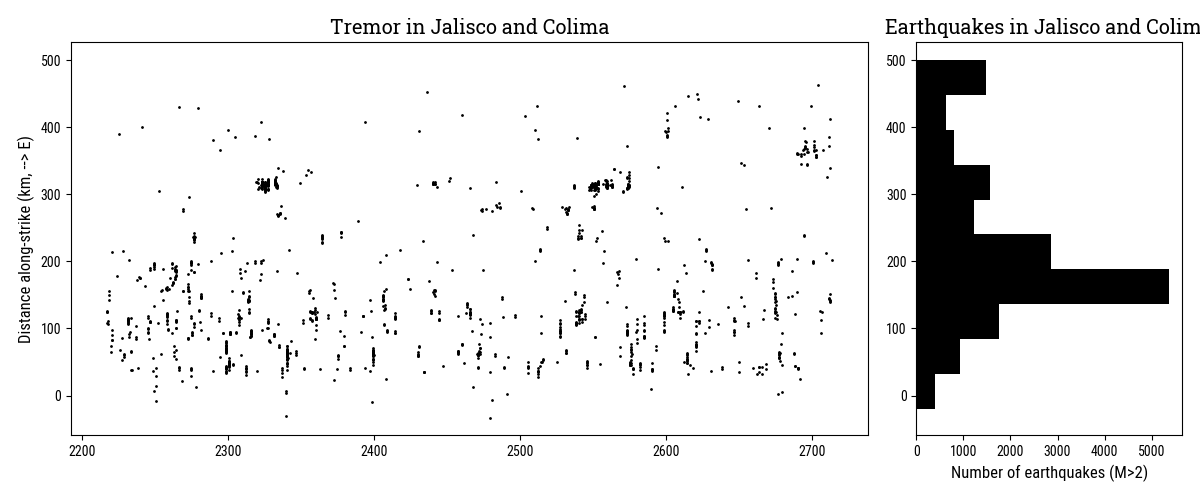

In [110]:
# Show the activity in space and time
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

ax = fig.add_subplot(gs[0])
ax.set_title('Tremor in Jalisco and Colima', fontname='Roboto Slab')
ax.set_ylabel('Distance along-strike (km, --> E)')

ax.plot(wtd_jc.day, wtd_jc.xf, 'o', color='k', markersize=1)

ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_title('Earthquakes in Jalisco and Colima', fontname='Roboto Slab')
ax.set_xlabel('Number of earthquakes (M>2)')

ax.hist(eq_jc.xf, bins=10, orientation='horizontal', color='k')

plt.tight_layout()

## 2.3. <a id='toc2_3_'></a>Load single station tremor detections for Guerrero and Oaxaca (Husker) [&#128285;](#toc0_)

In [42]:
# Load data
ARIG = {'name': 'ARIG', 'lon': -100.347494, 'lat': 19.280492}
YOIG = {'name': 'YOIG', 'lon': -97.54565, 'lat': 16.856545}
TXIG = {'name': 'TXIG', 'lon': -97.7676667, 'lat': 17.2532217}
stats = [ARIG, YOIG, TXIG]

delta = 24

# --> ARIG
path = workdir + 'projects/data/Catalogs/mexico_tremor/ARIG_tremor.txt'
arig_trm = pd.read_csv(path, delimiter=' ', names=['date', 'hour_start', 'hour_end', 'dur'], skiprows=16, index_col=False)

arig_trm['date'] = pd.to_datetime(arig_trm.date.astype(str), format='%Y.%j') + arig_trm.hour_start*np.timedelta64(1, 'h')
arig_trm['day'] = (arig_trm.date - day0) / np.timedelta64(1, 'D')

arig_time = np.arange(np.datetime64('2009-02-25'), np.datetime64('2018-01-18'), delta*np.timedelta64(1, 'h'))
arig_count = np.histogram(arig_trm.date.values, bins=arig_time)[0]
arig_dur = np.histogram(arig_trm.date.values, bins=arig_time, weights=arig_trm.dur.values)[0]

# --> YOIG
path = workdir + 'projects/data/Catalogs/mexico_tremor/YOIG_tremor.txt'
yoig_trm = pd.read_csv(path, delimiter=' ', names=['date', 'hour_start', 'hour_end', 'dur'], skiprows=16, index_col=False)

yoig_trm['date'] = pd.to_datetime(yoig_trm.date.astype(str), format='%Y.%j') + yoig_trm.hour_start*np.timedelta64(1, 'h')
yoig_trm['day'] = (yoig_trm.date - day0) / np.timedelta64(1, 'D')

yoig_time = np.arange(np.datetime64('2012-10-09'), np.datetime64('2018-06-03'), delta*np.timedelta64(1, 'h'))
yoig_count = np.histogram(yoig_trm.date.values, bins=yoig_time)[0]
yoig_dur = np.histogram(yoig_trm.date.values, bins=yoig_time, weights=yoig_trm.dur.values)[0]

# --> TXIG
path = workdir + 'projects/data/Catalogs/mexico_tremor/TXIG_tremor.txt'
txig_trm = pd.read_csv(path, delimiter=' ', names=['date', 'hour_start', 'hour_end', 'dur'], skiprows=16, index_col=False)

txig_trm['date'] = pd.to_datetime(txig_trm.date.astype(str), format='%Y.%j') + txig_trm.hour_start*np.timedelta64(1, 'h')
txig_trm['day'] = (txig_trm.date - day0) / np.timedelta64(1, 'D')

txig_time = np.arange(np.datetime64('2012-09-12'), np.datetime64('2018-06-03'), delta*np.timedelta64(1, 'h'))
txig_count = np.histogram(txig_trm.date.values, bins=txig_time)[0]
txig_dur = np.histogram(txig_trm.date.values, bins=txig_time, weights=txig_trm.dur.values)[0]

In [83]:
# Count earthquakes around each station
dmax = 50. # km
def distance(lat, lon, lat_ref, lon_ref):
    R = 6371. # km
    dlat = np.radians(lat - lat_ref)
    dlon = np.radians(lon - lon_ref)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat_ref)) * np.cos(np.radians(lat)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c
n_eq_arig = np.sum((distance(eq.lat.values, eq.lon.values, ARIG['lat'], ARIG['lon']) < dmax) & (eq.mag > 2.))
n_eq_yoig = np.sum((distance(eq.lat.values, eq.lon.values, YOIG['lat'], YOIG['lon']) < dmax) & (eq.mag > 2.))
n_eq_txig = np.sum((distance(eq.lat.values, eq.lon.values, TXIG['lat'], TXIG['lon']) < dmax) & (eq.mag > 2.))

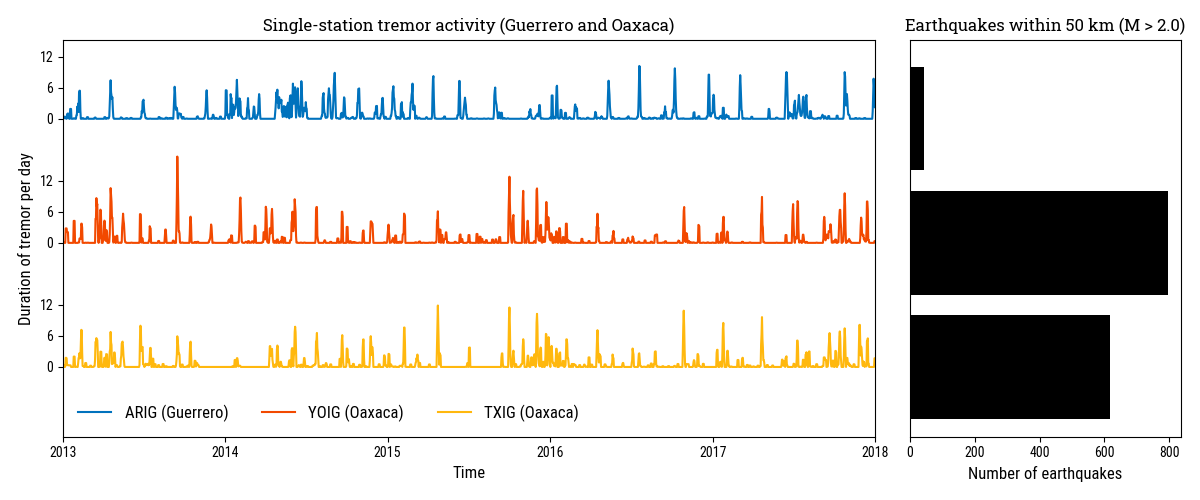

In [100]:
# Activity of tremor vs earthquakes
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

arig_dur_sm = np.convolve(arig_dur, np.ones(3)/3, mode='same')
yoig_dur_sm = np.convolve(yoig_dur, np.ones(3)/3, mode='same')
txig_dur_sm = np.convolve(txig_dur, np.ones(3)/3, mode='same')

ax = fig.add_subplot(gs[0])
ax.plot(arig_time[:-1], arig_dur_sm + 48, label='ARIG (Guerrero)')
ax.plot(yoig_time[:-1], yoig_dur_sm + 24, label='YOIG (Oaxaca)')
ax.plot(txig_time[:-1], txig_dur_sm, label='TXIG (Oaxaca)')

ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2018-01-01'))

ax.set_title('Single-station tremor activity (Guerrero and Oaxaca)', fontname='Roboto Slab', fontsize=12)
ax.set_ylabel('Duration of tremor per day')
ax.set_xlabel('Time')

ax.set_yticks([0, 6, 12, 24, 30, 36, 48, 54, 60])
ax.set_yticklabels([0, 6, 12, 0, 6, 12, 0, 6, 12])

ax.legend(ncols=3)

ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_title('Earthquakes within {:d} km (M > 2.0)'.format(int(dmax)), fontname='Roboto Slab', fontsize=12)
ax.set_xlabel('Number of earthquakes')

ax.barh([0, 24, 48], [n_eq_txig, n_eq_yoig, n_eq_arig], color='k', height=20)
ax.tick_params(labelleft=False, left=False)

plt.tight_layout()
plt.show()

## Map and show activity

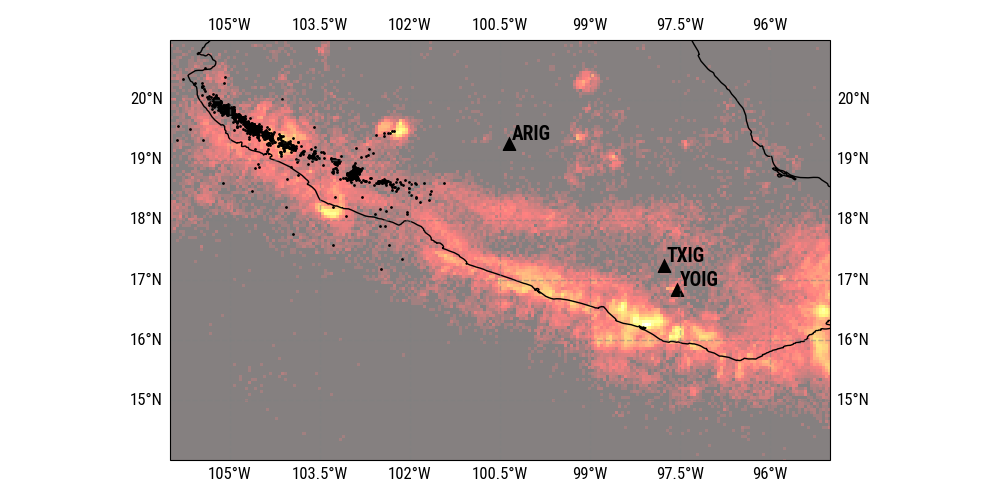

In [120]:
# Plot
fig = plt.figure(figsize=(10, 5))

lon_bins = np.arange(eq.lon.min(), eq.lon.max(), .05)
lat_bins = np.arange(eq.lat.min(), eq.lat.max(), .05)
hist, _, _ = np.histogram2d(eq.lon[eq.date > np.datetime64('2010-01-01')], eq.lat[eq.date > np.datetime64('2010-01-01')], bins=[lon_bins, lat_bins])

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([-106, -95, 14, 21])
ax.imshow(np.log10(hist+1).T, origin='lower', extent=[lon_bins.min(), lon_bins.max(), lat_bins.min(), lat_bins.max()],
            transform=ccrs.PlateCarree(), cmap='hot', alpha=.5)

ax.plot(wtd_jc.lon, wtd_jc.lat, 'o', color='k', markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

for st in stats:
    ax.plot(st['lon'], st['lat'], '^', color='k', mec=[0,0,0,0], markersize=10, transform=ccrs.PlateCarree())
    ax.annotate(st['name'], [st['lon'], st['lat']], xytext=[2,2], textcoords='offset points', color='black', fontsize=14, fontweight='bold')

# Add grid
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')


plt.tight_layout()
plt.show()